Prepared by Yifan Ren, Yinzhe Lu and prof Yilu Zhou.


Welcome to Lab 3! By completing the task of detecting scams, this lab will introduce <b>4 classifiers </b>:

1. naive bayes
2. decision tree
3. random forest
4. neural network (optional)

Also, we introduce <b>3 approaches</b> to construct features:
1. Bag-of-words
2. TFIDF
3. Word2Vec

Thus, we will have 12 accuracy results to compare in our final table!

In [2]:
pip install gensim

     |████████████████████████████████| 23.9 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 18.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install wordnet

  Created wheel for wordnet: filename=wordnet-0.0.1b2-py3-none-any.whl size=10520 sha256=770465a1e954a2e8fb022a0b0cd8144e61b8d2ca7d32cb4c71033e95a79801d8
  Stored in directory: /Users/nicolasclarke/Library/Caches/pip/wheels/c3/6b/0d/1364db2ed13d53eba854f1b31dcfb4cc56adc191e11147ed64
Successfully built wordnet
  Attempting uninstall: colorama
    Found existing installation: colorama 0.4.4
    Uninstalling colorama-0.4.4:
      Successfully uninstalled colorama-0.4.4
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install Levenshtein

     |████████████████████████████████| 80 kB 3.7 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nicolasclarke/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Import Packages

In [9]:
import matplotlib.pyplot as plt
import re
import os
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

import gensim

# Load Data

In [10]:
data = pd.read_csv("Spam Email.csv", usecols=["CATEGORY", "MESSAGE"])

In [11]:
data

,CATEGORY,MESSAGE
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ..."
1,1,ATTENTION: This is a MUST for ALL Computer Use...
2,1,This is a multi-part message in MIME format.\n...
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...
4,1,This is the bottom line. If you can GIVE AWAY...
...,...,...
5791,0,"I'm one of the 30,000 but it's not working ver..."
5792,0,Damien Morton quoted:\n\n>W3C approves HTML 4 ...
5793,0,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\..."
5794,0,"Once upon a time, Manfred wrote :\n\n\n\n> I w..."


In [12]:
data.info() 
#no further preprocessing for null values because of no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5796 entries, 0 to 5795
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CATEGORY  5796 non-null   int64 
 1   MESSAGE   5796 non-null   object
dtypes: int64(1), object(1)
memory usage: 90.7+ KB


In [13]:
data["CATEGORY"].value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

# Preprocessing

In [14]:
# remove non alphabets
remove_non_alphabets = lambda x: re.sub(r'[^a-zA-Z]',' ',x)

# tokenn alphabets-only list
tokenize = lambda x: word_tokenize(x)

# assign ps to a lambda function to run on each line of value
ps = PorterStemmer()
stem = lambda w: [ ps.stem(x) for x in w ]

# assign lemmatizer to a lambda function to run on each line of value
lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [ lemmatizer.lemmatize(word) for word in x ]

In [15]:
# apply all above methods to the column ''
print('Processing : [=', end='')
data['MESSAGE'] = data['MESSAGE'].apply(remove_non_alphabets)
print('=', end='')
data['MESSAGE'] = data['MESSAGE'].apply(tokenize)
print('=', end='')
data['MESSAGE'] = data['MESSAGE'].apply(stem)
print('=', end='')
data['MESSAGE'] = data['MESSAGE'].apply(leammtizer)
print('=', end='')
data['MESSAGE'] = data['MESSAGE'].apply(lambda x: ' '.join(x))
print('] : Completed', end='')
data.head()

Processing : [=====] : Completed

,CATEGORY,MESSAGE
0,1,dear homeown interest rate are at their lowest...
1,1,attent thi is a must for all comput user new s...
2,1,thi is a multi part messag in mime format next...
3,1,import inform the new domain name are final av...
4,1,thi is the bottom line If you can give away CD...


# Split Train-Test Sets

In [26]:
# split to 30 percent test data and 70 percent train data
# labels can be seen as y, an dependent variable
train_corpus, test_corpus, train_labels, test_labels = train_test_split(data["MESSAGE"],
                                                                        data["CATEGORY"],
                                                                        test_size=0.3)

# Construct Features for Machine Learning

## Bag-of-words

In [27]:
# build bag of words features' vectorizer and get features
bow_vectorizer=CountVectorizer(min_df=1, ngram_range=(1,1))
bow_train_features = bow_vectorizer.fit_transform(train_corpus)
bow_test_features = bow_vectorizer.transform(test_corpus)

## TFIDF

In [28]:
# build tfidf features' vectorizer and get features
tfidf_vectorizer=TfidfVectorizer(min_df=1, 
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=(1,1))
tfidf_train_features = tfidf_vectorizer.fit_transform(train_corpus)  
tfidf_test_features = tfidf_vectorizer.transform(test_corpus)    

## Word2Vec

In [1]:
# tokenize documents for word2vec
tokenized_train = [nltk.word_tokenize(text)
                   for text in train_corpus]
tokenized_test = [nltk.word_tokenize(text)
                   for text in test_corpus]  

# build word2vec model                   
wv_model = gensim.models.Word2Vec(tokenized_train,
                               size=200,                          #set the size or dimension for the word vectors 
                               window=60,                        #specify the length of the window of words taken as context
                               min_count=10)                   #ignores all words with total frequency lower than 10

def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector 
   

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

# averaged word vector features from word2vec
avg_wv_train_features = averaged_word_vectorizer(corpus=tokenized_train,
                                                 model=wv_model,
                                                 num_features=200)                   
avg_wv_test_features = averaged_word_vectorizer(corpus=tokenized_test,
                                                model=wv_model,
                                                num_features=200) 

NameError: name 'train_corpus' is not defined

# Define Evaluation Function

In [32]:
# define a function to evaluate our classification models based on four metrics
# This defined function is also useful in other cases. This is comparing test_y and pred_y. 
# Both contain 1s and 0s.
def get_metrics(true_labels, predicted_labels):
    metrics_dict = dict(zip(["accuracy", "precision", "recall", "f1"], [None]*4))
    #metrics_dict = {i:None for i in ["accuracy", "precision", "recall", "f1"]}
    for m in metrics_dict.keys():
        exec('''metrics_dict['{}'] = np.round(                                                    
                        metrics.{}_score(true_labels, 
                                               predicted_labels),
                        2)'''.format(m, m))
    return metrics_dict

# Define an Easy-to-use Function for Train/Test/Evaluate

In [33]:
# define a function that trains the model, performs predictions and evaluates the predictions
def train_predict_evaluate_model(classifier, 
                                 train_features, train_labels, 
                                 test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    # evaluate model prediction performance   
    '''get_metrics(true_labels=test_labels, 
                predicted_labels=predictions)'''
    print(metrics.classification_report(test_labels,predictions))
    return predictions, get_metrics(true_labels=test_labels, predicted_labels=predictions)   

# Import Classifiers

In [34]:
from sklearn.naive_bayes import MultinomialNB # import naive bayes
from sklearn.tree import DecisionTreeClassifier # import Decision Tree
from sklearn.ensemble import RandomForestClassifier # import random forest

# Train and Test on BOW features

In [35]:
# assign naive bayes function to an object
mnb = MultinomialNB()

# predict and evaluate naive bayes
mnb_bow_predictions, mnb_bow_metrics = train_predict_evaluate_model(classifier=mnb,
                                           train_features=bow_train_features,
                                           train_labels=train_labels,
                                           test_features=bow_test_features,
                                           test_labels=test_labels)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1179
           1       0.98      0.79      0.87       560

    accuracy                           0.93      1739
   macro avg       0.94      0.89      0.91      1739
weighted avg       0.93      0.93      0.92      1739



In [36]:
# assign decision tree function to an object
dt = DecisionTreeClassifier()

# predict and evaluate decision tree
dt_bow_predictions, dt_bow_metrics = train_predict_evaluate_model(classifier=dt,
                                                               train_features=bow_train_features,
                                                               train_labels=train_labels,
                                                               test_features=bow_test_features,
                                                               test_labels=test_labels)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1179
           1       0.91      0.94      0.93       560

    accuracy                           0.95      1739
   macro avg       0.94      0.95      0.95      1739
weighted avg       0.95      0.95      0.95      1739



In [37]:
# assign random forest function to an object
rf = RandomForestClassifier(criterion="entropy")

# predict and evaluate random forest
rf_bow_predictions, rf_bow_metrics = train_predict_evaluate_model(classifier=rf,
                                           train_features=bow_train_features,
                                           train_labels=train_labels,
                                           test_features=bow_test_features,
                                           test_labels=test_labels)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1179
           1       0.98      0.93      0.96       560

    accuracy                           0.97      1739
   macro avg       0.98      0.96      0.97      1739
weighted avg       0.97      0.97      0.97      1739



# Train and Test on TFIDF features

In [38]:
# predict and evaluate naive bayes
mnb_tfidf_predictions, mnb_tfidf_metrics = train_predict_evaluate_model(classifier=mnb,
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1179
           1       0.99      0.67      0.80       560

    accuracy                           0.89      1739
   macro avg       0.93      0.83      0.86      1739
weighted avg       0.90      0.89      0.89      1739



In [39]:
# predict and evaluate decision tree
dt_tfidf_predictions, dt_tfidf_metrics = train_predict_evaluate_model(classifier=dt,
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1179
           1       0.91      0.94      0.93       560

    accuracy                           0.95      1739
   macro avg       0.94      0.95      0.95      1739
weighted avg       0.95      0.95      0.95      1739



In [40]:
# predict and evaluate random forest
rf_tfidf_predictions, rf_tfidf_metrics = train_predict_evaluate_model(classifier=rf,
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1179
           1       0.99      0.92      0.96       560

    accuracy                           0.97      1739
   macro avg       0.98      0.96      0.97      1739
weighted avg       0.97      0.97      0.97      1739



# Train and Test on Word2Vec features

In [41]:
# predict and evaluate naive bayes
mnb_avgwv_predictions, mnb_avgwv_metrics = train_predict_evaluate_model(classifier=mnb,
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1179
           1       0.99      0.67      0.80       560

    accuracy                           0.89      1739
   macro avg       0.93      0.83      0.86      1739
weighted avg       0.90      0.89      0.89      1739



In [42]:
# predict and evaluate decision tree
dt_avgwv_predictions, dt_avgwv_metrics = train_predict_evaluate_model(classifier=dt,
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1179
           1       0.92      0.94      0.93       560

    accuracy                           0.95      1739
   macro avg       0.95      0.95      0.95      1739
weighted avg       0.96      0.95      0.95      1739



In [43]:
# predict and evaluate random forest
rf_avgwv_predictions, rf_avgwv_metrics = train_predict_evaluate_model(classifier=rf,
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1179
           1       0.99      0.93      0.96       560

    accuracy                           0.97      1739
   macro avg       0.98      0.96      0.97      1739
weighted avg       0.97      0.97      0.97      1739



# Visualize Performance Matrix

In [44]:
# create a dictionary that stores all the accuracy information
performance_dict = {}

for me in ["accuracy", "precision", "recall", "f1"]:
    performance_dict[me] = {}
    for m in ["mnb","dt","rf"]:
        performance_dict[me][m] = {}
        for f in ["bow","tfidf","avgwv"]:
            exec('performance_dict["{}"]["{}"]["{}"] = {}_{}_metrics["{}"]'.format(me, m, f, m, f, me))
        
#Accuracy Matrix
print("\n\033[1;31mAccuracy Metrix\n\033[0m")
print(pd.DataFrame(performance_dict["accuracy"]).rename(columns={"mnb":"Naive Bayes", 
                                            "dt":"Decision Tree", 
                                            "rf":"Random Forest"}, 
                                   index={"bow":"Bag-of-words", 
                                          "tfidf":"TFIDF", 
                                          "avgwv":"Word2Vec"}))

#Precision Matrix
print("\n\033[1;31mPrecision Metrix\n\033[0m")
print(pd.DataFrame(performance_dict["precision"]).rename(columns={"mnb":"Naive Bayes", 
                                            "dt":"Decision Tree", 
                                            "rf":"Random Forest"}, 
                                   index={"bow":"Bag-of-words", 
                                          "tfidf":"TFIDF", 
                                          "avgwv":"Word2Vec"}))

#Recall Matrix
print("\n\033[1;31mRecall Metrix\n\033[0m")
print(pd.DataFrame(performance_dict["recall"]).rename(columns={"mnb":"Naive Bayes", 
                                            "dt":"Decision Tree", 
                                            "rf":"Random Forest"}, 
                                   index={"bow":"Bag-of-words", 
                                          "tfidf":"TFIDF", 
                                          "avgwv":"Word2Vec"}))

#F1 Score Matrix
print("\n\033[1;31mF1 Score Metrix\n\033[0m")
print(pd.DataFrame(performance_dict["f1"]).rename(columns={"mnb":"Naive Bayes", 
                                            "dt":"Decision Tree", 
                                            "rf":"Random Forest"}, 
                                   index={"bow":"Bag-of-words", 
                                          "tfidf":"TFIDF", 
                                          "avgwv":"Word2Vec"}))


Accuracy Metrix

              Naive Bayes  Decision Tree  Random Forest
Bag-of-words         0.93           0.95           0.97
TFIDF                0.89           0.95           0.97
Word2Vec             0.89           0.95           0.97

Precision Metrix

              Naive Bayes  Decision Tree  Random Forest
Bag-of-words         0.98           0.91           0.98
TFIDF                0.99           0.91           0.99
Word2Vec             0.99           0.92           0.99

Recall Metrix

              Naive Bayes  Decision Tree  Random Forest
Bag-of-words         0.79           0.94           0.93
TFIDF                0.67           0.94           0.92
Word2Vec             0.67           0.94           0.92

F1 Score Metrix

              Naive Bayes  Decision Tree  Random Forest
Bag-of-words         0.87           0.93           0.96
TFIDF                0.80           0.93           0.96
Word2Vec             0.80           0.93           0.96


# (Optional) Feedforward Neural Network Classifier through PyTorch

In [46]:
pip install torch

     |████████████████████████████████| 119.6 MB 39.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

The feedforward neural network was the first and simplest type of artificial neural network devised. In this network, the information moves in only one direction—forward—from the input nodes, through the hidden nodes (if any), and to the output nodes. There are no cycles or loops in the network.

In [48]:
class LogisticRegression(nn.Module):
    def __init__(self, init_in_features):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(init_in_features, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

def Neural_Network_Classify(x_train, y_train, x_test, y_test, init_in_features):
    model = LogisticRegression(init_in_features = init_in_features)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters() , lr=0.01)
    
    if not isinstance(x_train, np.ndarray):
        x_train = x_train.toarray()
        x_test = x_test.toarray()
    x_train = Variable(torch.from_numpy(x_train)).float()
    y_train = Variable(torch.from_numpy(y_train.values)).long()

    epochs = 20
    model.train()
    loss_values = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        loss_values.append(loss.item())
        pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
        acc = pred * 100.0 / len(x_train)
        print('Epoch: {}, Loss: {}, Accuracy: {}%'.format(epoch+1, loss.item(), acc.numpy()))
        loss.backward()
        optimizer.step()

    plt.plot(loss_values)
    plt.title('Loss Value vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Loss'])
    plt.show()

    x_test = Variable(torch.from_numpy(x_test)).float()
    y_test = Variable(torch.from_numpy(y_test.values)).long()

    model.eval()
    with torch.no_grad():
        y_pred = model(x_test)
        loss = criterion(y_pred, y_test)
        pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
        accuracy_nn = float(pred/len(x_test))
        print ("Accuracy : {}%".format(100*accuracy_nn))

    return get_metrics(true_labels=y_test, predicted_labels=np.argmax(y_pred, axis=1)) 

Epoch: 1, Loss: 0.7158291339874268, Accuracy: 32.906089782714844%
Epoch: 2, Loss: 0.671406626701355, Accuracy: 32.93073654174805%
Epoch: 3, Loss: 0.676488995552063, Accuracy: 33.1525764465332%
Epoch: 4, Loss: 0.4886412024497986, Accuracy: 86.2459945678711%
Epoch: 5, Loss: 0.38467419147491455, Accuracy: 97.461181640625%
Epoch: 6, Loss: 0.2838684916496277, Accuracy: 98.24993896484375%
Epoch: 7, Loss: 0.19795532524585724, Accuracy: 99.16194152832031%
Epoch: 8, Loss: 0.13389693200588226, Accuracy: 99.3098373413086%
Epoch: 9, Loss: 0.09154841303825378, Accuracy: 99.359130859375%
Epoch: 10, Loss: 0.06460966169834137, Accuracy: 99.53167724609375%
Epoch: 11, Loss: 0.04623182862997055, Accuracy: 99.6795654296875%
Epoch: 12, Loss: 0.032156988978385925, Accuracy: 99.82746124267578%
Epoch: 13, Loss: 0.019609171897172928, Accuracy: 99.90140533447266%
Epoch: 14, Loss: 0.013455565087497234, Accuracy: 99.92605590820312%
Epoch: 15, Loss: 0.009882114827632904, Accuracy: 99.92605590820312%
Epoch: 16, Los

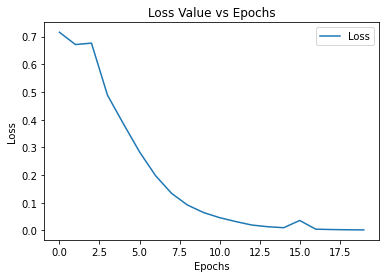

Accuracy : 98.50488901138306%


In [49]:
# predict and evaluate neural networks
nn_bow_metrics = Neural_Network_Classify(bow_train_features, 
                                          train_labels, 
                                          bow_test_features, 
                                          test_labels, 
                                          bow_train_features.shape[1])

In [ ]:
# predict and evaluate neural networks
nn_tfidf_metrics = Neural_Network_Classify(tfidf_train_features, 
                                            train_labels, 
                                            tfidf_test_features, 
                                            test_labels, 
                                            tfidf_train_features.shape[1])

Epoch: 1, Loss: 0.7556632161140442, Accuracy: 32.93073654174805%
Epoch: 2, Loss: 0.6971099376678467, Accuracy: 33.42371368408203%
Epoch: 3, Loss: 0.6180824041366577, Accuracy: 91.96450805664062%
Epoch: 4, Loss: 0.5235825777053833, Accuracy: 89.79541778564453%
Epoch: 5, Loss: 0.431026816368103, Accuracy: 88.29183959960938%
Epoch: 6, Loss: 0.3544023931026459, Accuracy: 88.73551940917969%
Epoch: 7, Loss: 0.2998507022857666, Accuracy: 90.36233520507812%
Epoch: 8, Loss: 0.25663143396377563, Accuracy: 93.51737976074219%
Epoch: 9, Loss: 0.2202076017856598, Accuracy: 96.05619812011719%
Epoch: 10, Loss: 0.19065894186496735, Accuracy: 98.0280990600586%
Epoch: 11, Loss: 0.16851812601089478, Accuracy: 99.45772552490234%
Epoch: 12, Loss: 0.15150964260101318, Accuracy: 99.85210418701172%
Epoch: 13, Loss: 0.13478706777095795, Accuracy: 99.92605590820312%
Epoch: 14, Loss: 0.11722756177186966, Accuracy: 99.90140533447266%
Epoch: 15, Loss: 0.09929285943508148, Accuracy: 99.92605590820312%


In [ ]:
# predict and evaluate neural networks
nn_avgwv_metrics = Neural_Network_Classify(avg_wv_train_features, 
                                            train_labels, 
                                            avg_wv_test_features, 
                                            test_labels, 
                                            avg_wv_train_features.shape[1])

In [ ]:
# create a dictionary that stores all the accuracy information
performance_dict = {}

for me in ["accuracy", "precision", "recall", "f1"]:
    performance_dict[me] = {}
    for m in ["mnb","dt","rf", "nn"]:
        performance_dict[me][m] = {}
        for f in ["bow","tfidf","avgwv"]:
            exec('performance_dict["{}"]["{}"]["{}"] = {}_{}_metrics["{}"]'.format(me, m, f, m, f, me))
        
#Accuracy Matrix
print("\n\033[1;31mAccuracy Metrix\n\033[0m")
print(pd.DataFrame(performance_dict["accuracy"]).rename(columns={"mnb":"Naive Bayes", 
                                            "dt":"Decision Tree", 
                                            "rf":"Random Forest",
                                            "nn":"Neural Network"}, 
                                   index={"bow":"Bag-of-words", 
                                          "tfidf":"TFIDF", 
                                          "avgwv":"Word2Vec"}))

#Precision Matrix
print("\n\033[1;31mPrecision Metrix\n\033[0m")
print(pd.DataFrame(performance_dict["precision"]).rename(columns={"mnb":"Naive Bayes", 
                                            "dt":"Decision Tree", 
                                            "rf":"Random Forest",
                                            "nn":"Neural Network"}, 
                                   index={"bow":"Bag-of-words", 
                                          "tfidf":"TFIDF", 
                                          "avgwv":"Word2Vec"}))

#Recall Matrix
print("\n\033[1;31mRecall Metrix\n\033[0m")
print(pd.DataFrame(performance_dict["recall"]).rename(columns={"mnb":"Naive Bayes", 
                                            "dt":"Decision Tree", 
                                            "rf":"Random Forest",
                                            "nn":"Neural Network"}, 
                                   index={"bow":"Bag-of-words", 
                                          "tfidf":"TFIDF", 
                                          "avgwv":"Word2Vec"}))

#F1 Score Matrix
print("\n\033[1;31mF1 Score Metrix\n\033[0m")
print(pd.DataFrame(performance_dict["f1"]).rename(columns={"mnb":"Naive Bayes", 
                                            "dt":"Decision Tree", 
                                            "rf":"Random Forest",
                                            "nn":"Neural Network"}, 
                                   index={"bow":"Bag-of-words", 
                                          "tfidf":"TFIDF", 
                                          "avgwv":"Word2Vec"}))

That's all for this lab. See how feature generation and model classifiers improve our result!